<a href="https://colab.research.google.com/github/SvetlanaTsim/ml_in_business/blob/main/lesson_03/HW3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Урок3. Связь бизнес-показателей и DS-метрик

### Домашнее задание

1. обучить несколько разных моделей на наборе данных ССЗ (train_case2.csv): логрег, бустинг, лес и т.д - на ваш выбор 2-3 варианта
2. при обучении моделей обязательно использовать кроссвалидацию
3. вывести сравнение полученных моделей по основным метрикам классификации: pr/rec/auc/f_score (можно в виде таблицы, где строки - модели, а столбцы - метрики)
4. сделать выводы о том, какая модель справилась с задачей лучше других
5. (опциональный вопрос) какая метрика (precision_recall_curve или roc_auc_curve) больше подходит в случае сильного дисбаланса классов? (когда объектов одного из классов намного больше чем другого). 

p.s.В вопросе проще разобраться, если вспомнить оси на графике roc auc curve и рассмотреть такой пример:

Имеется 100000 объектов, из которых только 100 - класс "1" (99900 - класс "0", соответственно). 
Допустим, у нас две модели:

- первая помечает 100 объектов как класс 1, но TP = 90
- вторая помечает 1000 объектов как класс 1, но TP такой же - 90

Какая модель лучше и почему? И что позволяет легче сделать вывод - roc_auc_curve или precision_recall_curve?

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, confusion_matrix
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from scipy.sparse import hstack
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
import itertools

In [11]:
#загрузим данные

!wget 'https://drive.google.com/uc?export=download&id=1Si4EJ_RexI3Q7yZU8eLjgp4ORe_BXr4G' -O train_case2.csv

--2022-12-20 13:22:16--  https://drive.google.com/uc?export=download&id=1Si4EJ_RexI3Q7yZU8eLjgp4ORe_BXr4G
Resolving drive.google.com (drive.google.com)... 108.177.12.113, 108.177.12.139, 108.177.12.138, ...
Connecting to drive.google.com (drive.google.com)|108.177.12.113|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-00-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/llepl438t3ehhqmj67jipcrtcmqth8rk/1671542475000/14904333240138417226/*/1Si4EJ_RexI3Q7yZU8eLjgp4ORe_BXr4G?e=download&uuid=a4952599-87f6-485e-b2a2-6aeb2a63892e [following]
--2022-12-20 13:22:16--  https://doc-00-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/llepl438t3ehhqmj67jipcrtcmqth8rk/1671542475000/14904333240138417226/*/1Si4EJ_RexI3Q7yZU8eLjgp4ORe_BXr4G?e=download&uuid=a4952599-87f6-485e-b2a2-6aeb2a63892e
Resolving doc-00-c0-docs.googleusercontent.com (doc-00-c0-docs.googleusercontent.com)... 108.177.12.132, 2607:

In [12]:
df = pd.read_csv('train_case2.csv', ';')

df.head(3)

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  exec(code_obj, self.user_global_ns, self.user_ns)


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1


In [13]:
#пропусков нет

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


In [14]:
#разделим наши данные на тренировочную и тестовую выборки

X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='cardio'), 
                                                    df['cardio'], random_state=0)

К полям:
- gender, cholesterol применим OHE-кодирование
- age, height, weight, ap_hi, ap_lo - standardScaler
- gluc, smoke, alco, active - оставим пока как есть

In [15]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]


from sklearn.preprocessing import StandardScaler


continuos_cols = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']
cat_cols = ['gender', 'cholesterol']
base_cols = ['gluc', 'smoke', 'alco', 'active']

continuos_transformers = []
cat_transformers = []
base_transformers = []

for cont_col in continuos_cols:
    transfomer =  Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler())
            ])
    continuos_transformers.append((cont_col, transfomer))
    
for cat_col in cat_cols:
    cat_transformer = Pipeline([
                ('selector', ColumnSelector(key=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    cat_transformers.append((cat_col, cat_transformer))
    
for base_col in base_cols:
    base_transformer = Pipeline([
                ('selector', NumberSelector(key=base_col))
            ])
    base_transformers.append((base_col, base_transformer))

Теперь объединим все наши трансформеры с помощью FeatureUnion

In [16]:
#посмотрим списки

continuos_transformers+cat_transformers+base_transformers

[('age', Pipeline(steps=[('selector', NumberSelector(key='age')),
                  ('standard', StandardScaler())])),
 ('height', Pipeline(steps=[('selector', NumberSelector(key='height')),
                  ('standard', StandardScaler())])),
 ('weight', Pipeline(steps=[('selector', NumberSelector(key='weight')),
                  ('standard', StandardScaler())])),
 ('ap_hi', Pipeline(steps=[('selector', NumberSelector(key='ap_hi')),
                  ('standard', StandardScaler())])),
 ('ap_lo', Pipeline(steps=[('selector', NumberSelector(key='ap_lo')),
                  ('standard', StandardScaler())])),
 ('gender', Pipeline(steps=[('selector', ColumnSelector(key='gender')),
                  ('ohe', OHEEncoder(key='gender'))])),
 ('cholesterol',
  Pipeline(steps=[('selector', ColumnSelector(key='cholesterol')),
                  ('ohe', OHEEncoder(key='cholesterol'))])),
 ('gluc', Pipeline(steps=[('selector', NumberSelector(key='gluc'))])),
 ('smoke', Pipeline(steps=[('selector', N

In [17]:
from sklearn.pipeline import FeatureUnion

feats = FeatureUnion(continuos_transformers+cat_transformers+base_transformers)
feature_processing = Pipeline([('feats', feats)])

feature_processing.fit_transform(X_train)

array([[-1.73391771,  0.6873301 ,  0.74843904, ...,  1.        ,
         0.        ,  1.        ],
       [-1.67343538,  0.07758923, -0.29640123, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.13738132,  1.17512278, -0.15708919, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.17775864,  1.17512278, -0.15708919, ...,  0.        ,
         0.        ,  1.        ],
       [-0.47190715, -1.38578883,  0.74843904, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.38174619,  0.56538192, -0.08743318, ...,  0.        ,
         0.        ,  1.        ]])

Добавим классификатор - Логистическую регресиию и запустим кросс-валидацию

In [18]:
classifier_lr = Pipeline([
    ('features', feats),
    ('classifier_lr', LogisticRegression(random_state=42)),
])


# запустим кросс-валидацию
cv_scores = cross_val_score(classifier_lr, X_train, y_train, cv=7, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print(f'CV score is {cv_score}+-{cv_score_std}')

# обучим пайплайн на всем тренировочном датасете
classifier_lr.fit(X_train, y_train)
y_score = classifier_lr.predict_proba(X_test)[:, 1]

CV score is 0.7864573689384385+-0.004422021036885763


Посчитаем precision/recall/f_score/roc_auc_score

In [19]:
b = 1
precision, recall, thresholds = precision_recall_curve(y_test.values, y_score)
fscore = (1 +b**2) * (precision * recall) / (b**2 * precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')

Best Threshold=0.3869370891147379, F-Score=0.730, Precision=0.647, Recall=0.838


In [29]:
from sklearn.metrics import roc_auc_score

roc_auc_lr = roc_auc_score(y_test, classifier_lr.predict_proba(X_test)[:, 1])

print(f"roc auc score: {roc_auc_score(y_train, classifier_lr.predict_proba(X_train)[:, 1])}")

print(f"roc auc score: {roc_auc_lr}")

roc auc score: 0.7870081561637485
roc auc score: 0.7840347790421852


Посмотрим на матрицу ошибок

In [24]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[4861 3959]
 [1411 7269]]


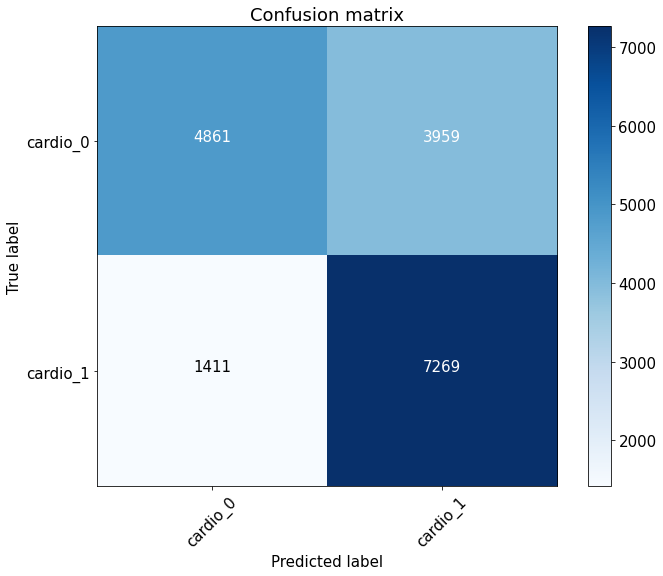

In [25]:
# мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, y_score > thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['cardio_0', 'cardio_1'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [26]:
TP = cnf_matrix[1, 1]
FP = cnf_matrix[0, 1]
TN = cnf_matrix[0, 0]
FN = cnf_matrix[1, 0]

TP, FP, TN, FN

(7269, 3959, 4861, 1411)

Посчитаем расходы на обследование и лечение в случае использование модели

Пусть:

- стоимость лечения 15000р, если сделали тест и начали лечить вовремя
- стоимость лечения 20000р, если упустили и начали лечить когда уже проявились все симптомы
- стоимость теста 1400р



- лишних тестов сделали FP = cnf_matrix[0][1]
- пропустили больных FN = cnf_matrix[1][0]
- правильных тестов сделали TP = cnf_matrix[1][1]

In [27]:
ML_costs = (FP * 1400) + (TP * (1400 + 15000)) + FN * 20000

ML_costs

152974200

Сформируем таблицу с результатами

In [36]:
metrics_df = pd.DataFrame(columns=['Model', 'Thresh', 'F-Score', 'Precision', 'Recall', 'Roc_auc', 'ML_costs'])
metrics_df

,Model,Thresh,F-Score,Precision,Recall,Roc_auc,ML_costs


In [37]:
metrics_df = metrics_df.append({
    'Model': type(classifier_lr['classifier_lr']).__name__,
    'Thresh': thresholds[ix],
    'F-Score': fscore[ix],
    'Precision': precision[ix],
    'Recall': recall[ix],
    'Roc_auc': roc_auc_lr,
    'ML_costs': ML_costs
  }, ignore_index=True)

In [38]:
metrics_df

,Model,Thresh,F-Score,Precision,Recall,Roc_auc,ML_costs
0,LogisticRegression,0.386937,0.730323,0.647431,0.837558,0.784035,152974200


Градиентный бустинг


In [39]:
from sklearn.ensemble import GradientBoostingClassifier

In [41]:
classifier_gb = Pipeline([
    ('features', feats),
    ('classifier_gb', GradientBoostingClassifier(random_state=42)),
])

In [43]:
# запустим кросс-валидацию
cv_scores = cross_val_score(classifier_gb, X_train, y_train, cv=7, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print(f'CV score is {cv_score}+-{cv_score_std}')

# обучим пайплайн на всем тренировочном датасете
classifier_gb.fit(X_train, y_train)
y_score = classifier_gb.predict_proba(X_test)[:, 1]

CV score is 0.8023336401314394+-0.003067762759094604


Посчитаем precision/recall/f_score/roc_auc_score

In [44]:
b = 1
precision, recall, thresholds = precision_recall_curve(y_test.values, y_score)
fscore = (1 +b**2) * (precision * recall) / (b**2 * precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')

Best Threshold=0.39494659702686624, F-Score=0.740, Precision=0.698, Recall=0.788


In [45]:
roc_auc_gb = roc_auc_score(y_test, classifier_gb.predict_proba(X_test)[:, 1])

print(f"roc auc score: {roc_auc_score(y_train, classifier_gb.predict_proba(X_train)[:, 1])}")

print(f"roc auc score: {roc_auc_gb}")

roc auc score: 0.8076553421213264
roc auc score: 0.8026153641179974


Confusion matrix, without normalization
[[5858 2962]
 [1840 6840]]


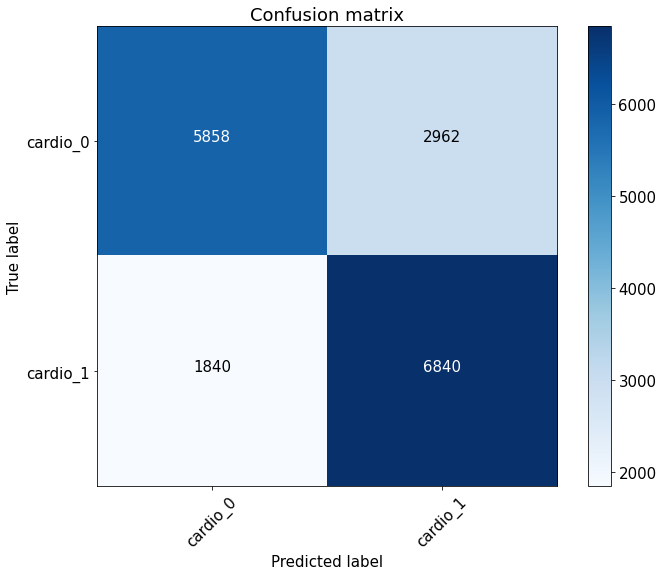

In [46]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, y_score > thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['cardio_0', 'cardio_1'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [47]:
TP = cnf_matrix[1, 1]
FP = cnf_matrix[0, 1]
TN = cnf_matrix[0, 0]
FN = cnf_matrix[1, 0]

TP, FP, TN, FN

(6840, 2962, 5858, 1840)

In [48]:
ML_costs = (FP * 1400) + (TP * (1400 + 15000)) + FN * 20000

ML_costs

153122800

In [49]:
metrics_df = metrics_df.append({
    'Model': type(classifier_gb['classifier_gb']).__name__,
    'Thresh': thresholds[ix],
    'F-Score': fscore[ix],
    'Precision': precision[ix],
    'Recall': recall[ix],
    'Roc_auc': roc_auc_gb,
    'ML_costs': ML_costs
  }, ignore_index=True)

metrics_df

,Model,Thresh,F-Score,Precision,Recall,Roc_auc,ML_costs
0,LogisticRegression,0.386937,0.730323,0.647431,0.837558,0.784035,152974200
1,GradientBoostingClassifier,0.394947,0.740248,0.697848,0.788134,0.802615,153122800


Случайный лес


In [50]:
from sklearn.ensemble import RandomForestClassifier

In [51]:
classifier_rf = Pipeline([
    ('features', feats),
    ('classifier_rf', RandomForestClassifier(random_state=42)),
])

In [52]:
# запустим кросс-валидацию
cv_scores = cross_val_score(classifier_rf, X_train, y_train, cv=7, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print(f'CV score is {cv_score}+-{cv_score_std}')

# обучим пайплайн на всем тренировочном датасете
classifier_rf.fit(X_train, y_train)
y_score = classifier_rf.predict_proba(X_test)[:, 1]

CV score is 0.7743796633622809+-0.003611330100912611


Посчитаем precision/recall/f_score/roc_auc_score

In [53]:
b = 1
precision, recall, thresholds = precision_recall_curve(y_test.values, y_score)
fscore = (1 +b**2) * (precision * recall) / (b**2 * precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')

Best Threshold=0.35, F-Score=0.719, Precision=0.643, Recall=0.816


In [54]:
roc_auc_rf = roc_auc_score(y_test, classifier_rf.predict_proba(X_test)[:, 1])

print(f"roc auc score: {roc_auc_score(y_train, classifier_gb.predict_proba(X_train)[:, 1])}")

print(f"roc auc score: {roc_auc_gb}")

roc auc score: 0.8076553421213264
roc auc score: 0.8026153641179974


Confusion matrix, without normalization
[[4991 3829]
 [1663 7017]]


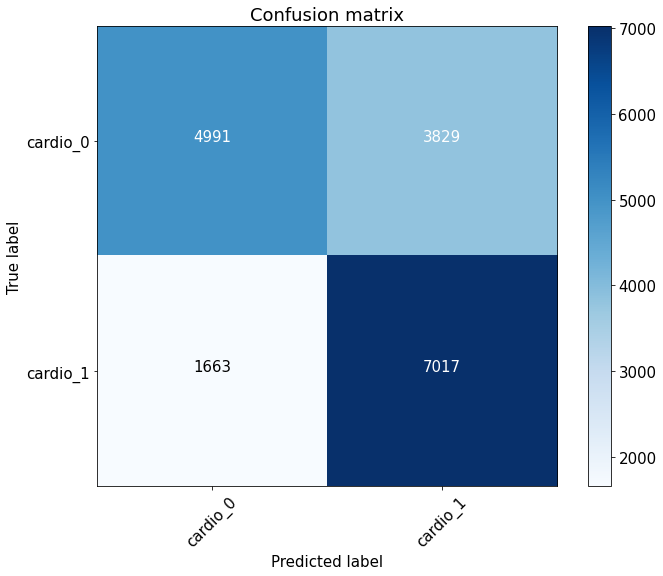

In [56]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, y_score > thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['cardio_0', 'cardio_1'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [57]:
TP = cnf_matrix[1, 1]
FP = cnf_matrix[0, 1]
TN = cnf_matrix[0, 0]
FN = cnf_matrix[1, 0]

TP, FP, TN, FN

(7017, 3829, 4991, 1663)

In [58]:
ML_costs = (FP * 1400) + (TP * (1400 + 15000)) + FN * 20000

ML_costs

153699400

In [60]:
metrics_df = metrics_df.append({
    'Model': type(classifier_rf['classifier_rf']).__name__,
    'Thresh': thresholds[ix],
    'F-Score': fscore[ix],
    'Precision': precision[ix],
    'Recall': recall[ix],
    'Roc_auc': roc_auc_rf,
    'ML_costs': ML_costs
  }, ignore_index=True)

metrics_df

,Model,Thresh,F-Score,Precision,Recall,Roc_auc,ML_costs
0,LogisticRegression,0.386937,0.730323,0.647431,0.837558,0.784035,152974200
1,GradientBoostingClassifier,0.394947,0.740248,0.697848,0.788134,0.802615,153122800
2,RandomForestClassifier,0.350000,0.718863,0.642669,0.815553,0.771037,153699400


**Выводы**

Попробуем сделать выводы о том, какая модель справилась с задачей лучше других:

С точки зрения DS-метрик лучший результат показала модель GradientBoostingClassifier:


0.740248	0.697848	0.788134	0.802615

С точки зрения затрат на обследование и лечение лучший (наименьший) результат у модели LogisticRegression: 

152974200

Думаю так получилось потому, что стоимость разных видов обследования и лечения разная и LR показала наименьший результат FalseNegative, которые в итоге имеют самое дорогое лечение. Так как таких случаем меньше, это уменьшило общие затраты. 


###Вопрос 5

5. (опциональный вопрос) какая метрика (precision_recall_curve или roc_auc_curve) больше подходит в случае сильного дисбаланса классов? (когда объектов одного из классов намного больше чем другого). 

p.s.В вопросе проще разобраться, если вспомнить оси на графике roc auc curve и рассмотреть такой пример:

Имеется 100000 объектов, из которых только 100 - класс "1" (99900 - класс "0", соответственно). 
Допустим, у нас две модели:

- первая помечает 100 объектов как класс 1, но TP = 90
- вторая помечает 1000 объектов как класс 1, но TP такой же - 90

Какая модель лучше и почему? И что позволяет легче сделать вывод - roc_auc_curve или precision_recall_curve?

In [61]:
total = 100000
cl_1 =  100
cl_0 = 99900

#Модель 1

m_1_chosen = 100
m_1_TP = 90
m_1_TN = 99890
m_1_FP = 10
m_1_FN = 10

#Модель 2
#вторая помечает 1000 объектов как класс 1, но TP такой же - 90

m_2_chosen = 1000
m_2_TP = 90
m_2_TN = 98990
m_2_FP = 910
m_2_FN = 10

<center>$\large precision = \LARGE \frac{TP}{TP \: + \: FP} \:\:\:\:\: \large recall = \LARGE \frac{TP}{TP \: + \: FN}$<center>

In [63]:
precision_m_1 = m_1_TP / (m_1_TP + m_1_FP)
precision_m_1

0.9

In [64]:
recall_m_1 = m_1_TP / (m_1_TP + m_1_FN)
recall_m_1

0.9

In [66]:
b = 1
fscore_m_1 = (1 +b**2) * (precision_m_1 * recall_m_1) / (b**2 * precision_m_1 + recall_m_1)
fscore_m_1

0.9

In [67]:
#Во второй модели precision хуже в 10 раз, а recall такой же
precision_m_2 = m_2_TP / (m_2_TP + m_2_FP)

recall_m_2 = m_2_TP / (m_2_TP + m_2_FN)

precision_m_2, recall_m_2

(0.09, 0.9)

In [68]:
#fscore тоже гораздо хуже 
b = 1
fscore_m_2 = (1 +b**2) * (precision_m_2 * recall_m_2) / (b**2 * precision_m_2 + recall_m_2)
fscore_m_2

0.16363636363636364

**PR-кривая**

Графичекая характеристика качества бинарного классификатора, отображает зависимость изменения точности алгоритма от его полноты.

Таким образом pr-кривая учитывает и характеристики точности, и полноты (которые гораздо хуже у второй модели)

Пример изображения

<img src="https://drive.google.com/uc?id=1rsv2T7GAJ_WlwLAVjuWVER8v4LCu_gyX">

**ROC-кривая + ROC-AUC**

Графичекая характеристика качества бинарного классификатора, отображает зависимость доли верных положительных классификаций *True Positive Rate (TPR)* от доли ложных положительных классификаций *False Positive Rate (FPR)*.

Пример изображения 

<img src="https://drive.google.com/uc?id=13Wiu3kwC2dUudllku3Q4zpr3YpK4_ICg">

Посчитаем TPR и FPR для обеиих моделей

<center>$\large TPR = \LARGE \frac{TP}{TP \: + \: FN} \:\:\:\:\: \large FPR = \LARGE \frac{FP}{FP \: + \: TN}$<center>

In [69]:
#Модель 1

TPR_m_1  =  recall_m_1

FPR_m_1 = m_1_FP / (m_1_FP + m_1_TN)

TPR_m_1, FPR_m_1

(0.9, 0.0001001001001001001)

In [70]:
#Модель 2

TPR_m_2  =  recall_m_2

FPR_m_2 = m_2_FP / (m_2_FP + m_2_TN)

TPR_m_2, FPR_m_2

(0.9, 0.00910910910910911)

Реальные графики к сожалению не сможем построить, так как они строятся с перемещением thresholds и изменения параметров, а в данной задаче даны только результаты. 

И всё же понятно, что при небаллансированной выборке больше подходит pr-кривая, которая учитывает, как precision, так и recall 

В то время как roc-кривая учитывает recall и не учитывает precision (то есть ошибки FP - сколько неверно нашли 1 класс). 

Так же с помощью f-меры хорошо видно, что гораздо лучше 1я модель. 